In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

# **Visualizing Classes**

In [2]:
train_dir = r'C:\Users\ASUS\Desktop\senti_new\train'
test_dir = r'C:\Users\ASUS\Desktop\senti_new\test'

def Classes_Count(path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        Full_Path = os.path.join(path, Class)  # Use os.path.join to create a valid path
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)


In [3]:
pd.concat([Train_Count,Test_Count] , axis=1)

Train  Test
happy      7215  1774
neutral    4965  1233
sad        4830  1247
fear       4097  1024
angry      3995   958
surprise   3171   831
disgust     436   111

<Axes: >

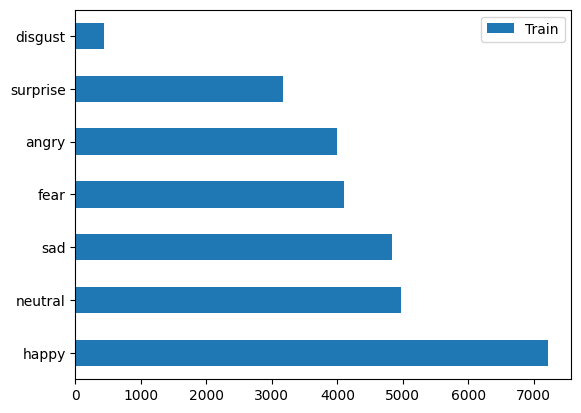

In [4]:
Train_Count.plot(kind='barh')

<Axes: >

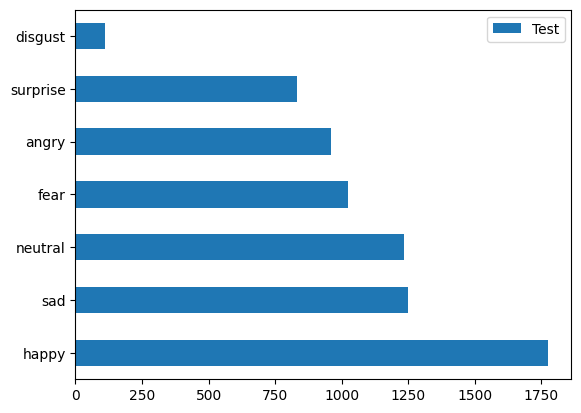

In [5]:
Test_Count.plot(kind='barh')

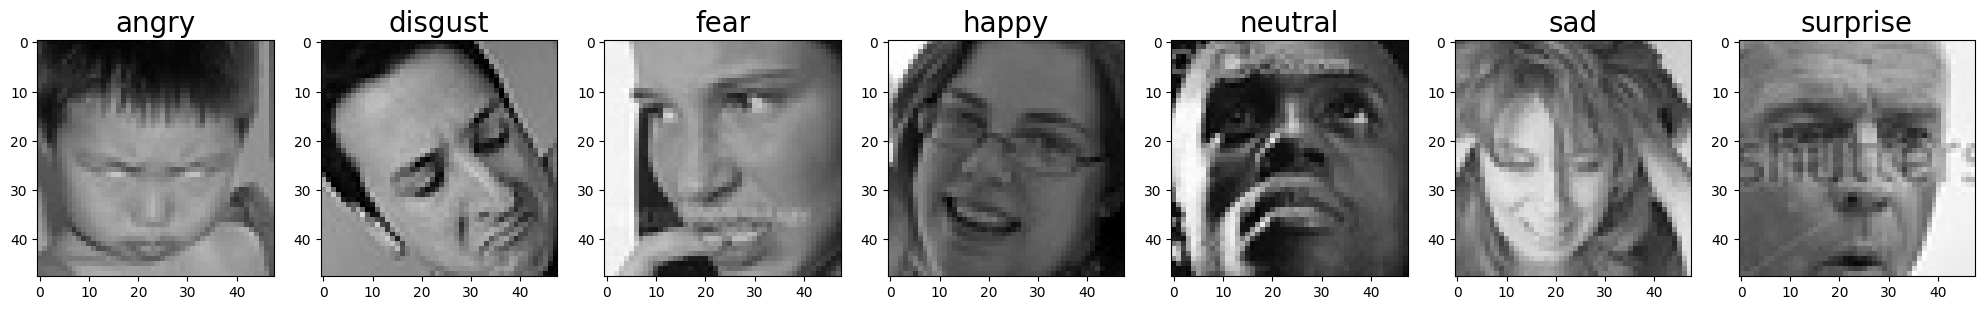

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(25, 8))
image_count = 1
BASE_URL = r'C:\Users\ASUS\Desktop\senti_new\train'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        directory_path = os.path.join(BASE_URL, directory)  # Create the full path to the directory
        if os.path.isdir(directory_path):
            for i, file in enumerate(os.listdir(directory_path)):
                if i == 1:
                    break
                else:
                    fig = plt.subplot(1, 7, image_count)
                    image_count += 1
                    image = cv2.imread(os.path.join(directory_path, file))  # Use os.path.join to create file path
                    plt.imshow(image)
                    plt.title(directory, fontsize=20)

plt.show()


# **Data Preprocessing**

In [7]:
img_shape = 48
batch_size = 64
train_data_path = r'C:\Users\ASUS\Desktop\senti_new\train'
test_data_path = r'C:\Users\ASUS\Desktop\senti_new\test'

In [8]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Building CNN Model**

In [9]:
def Create_CNN_Model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    
    #Output
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(7,activation='softmax'))
    
    
    return model

In [10]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                        

**Specifying Callbacks**

In [11]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [12]:
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=20, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - 277s 609ms/step - loss: 2.0273 - accuracy: 0.2181 - val_loss: 1.7966 - val_accuracy: 0.2553 - lr: 0.0010
Epoch 2/20
448/448 [==============================] - 266s 593ms/step - loss: 1.7561 - accuracy: 0.2908 - val_loss: 1.7070 - val_accuracy: 0.3308 - lr: 0.0010
Epoch 3/20
448/448 [==============================] - 264s 588ms/step - loss: 1.6251 - accuracy: 0.3569 - val_loss: 1.5225 - val_accuracy: 0.4033 - lr: 0.0010
Epoch 4/20
448/448 [==============================] - 263s 588ms/step - loss: 1.5056 - accuracy: 0.4126 - val_loss: 1.4525 - val_accuracy: 0.4435 - lr: 0.0010
Epoch 5/20
448/448 [==============================] - 265s 592ms/step - loss: 1.4210 - accuracy: 0.4545 - val_loss: 1.3120 - val_accuracy: 0.4936 - lr: 0.0010
Epoch 6/20
448/448 [==============================] - 268s 598ms/step - loss: 1.3638 - accuracy: 0.4767 - val_loss: 1.2331 - val_accuracy: 0.5223 - lr: 0.0010
Epoch 7/20
448/448 [==========================

# **Evaluating CNN Model**

In [13]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

113/113 [==============================] - 11s 93ms/step - loss: 0.9719 - accuracy: 0.6371
    Test Loss: 0.97193
Test Accuracy: 63.71%


In [14]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
  
  #plt.tight_layout()

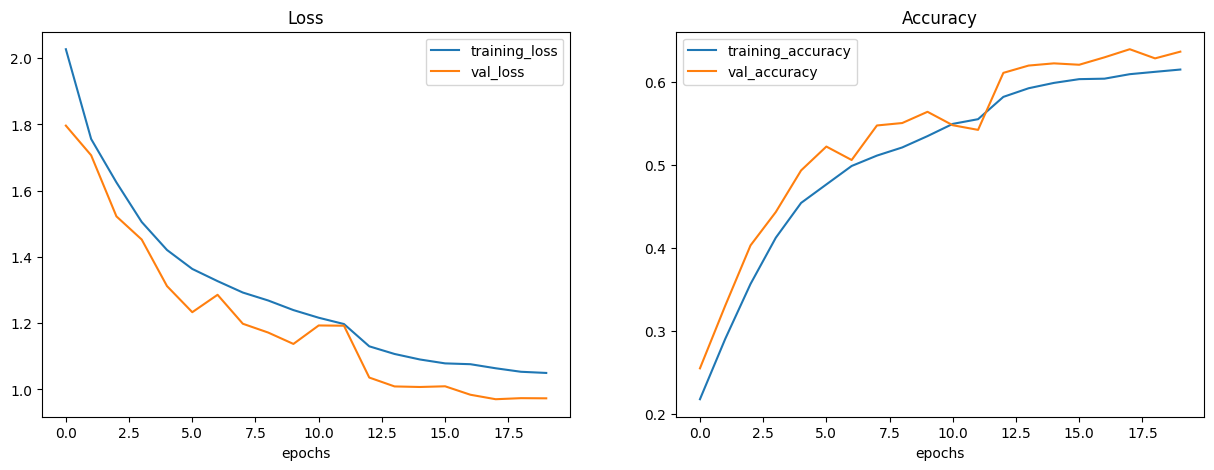

In [15]:
plot_curves(CNN_history)

In [16]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

113/113 [==============================] - 11s 92ms/step


In [17]:
test_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Text(0.5, 1.0, 'CNN Confusion Matrix')

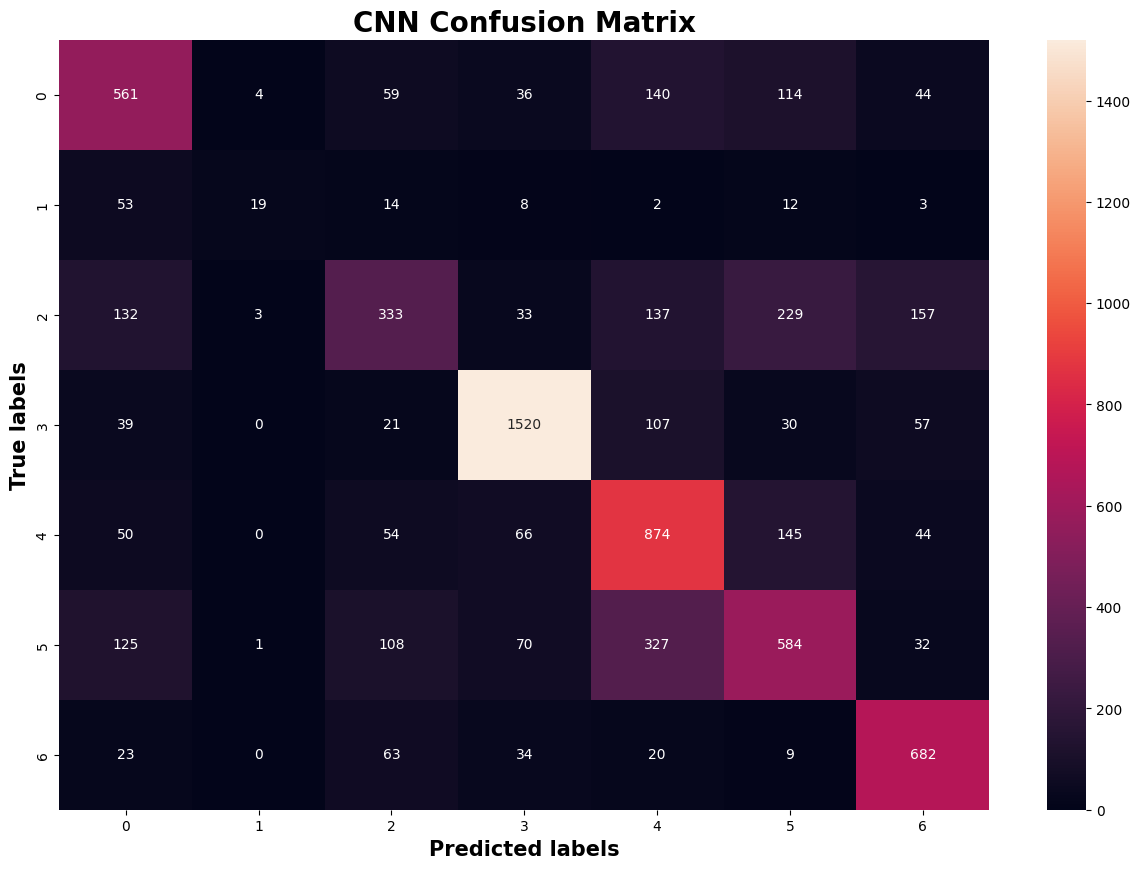

In [18]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

# **ResNet50V2 Model**

In [19]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
train_data_path = r'C:\Users\ASUS\Desktop\senti_new\train'
test_data_path = r'C:\Users\ASUS\Desktop\senti_new\test'


In [20]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Fine-Tuning ResNet50V2**

In [21]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

#ResNet50V2.summary()

In [22]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [23]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [24]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_12 (Ba  (None, 7, 7, 2048)        8192      
 tchNormalization)                                               
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_13 (Ba  (None, 64)                256       
 tchNormalization)                                    

**Specifying Callbacks**

In [25]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [26]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=20, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - 2872s 6s/step - loss: 1.5157 - accuracy: 0.4738 - val_loss: 1.4033 - val_accuracy: 0.5665 - lr: 0.0010
Epoch 2/20
448/448 [==============================] - 3288s 7s/step - loss: 1.1864 - accuracy: 0.5739 - val_loss: 1.1062 - val_accuracy: 0.5960 - lr: 0.0010
Epoch 3/20
448/448 [==============================] - 3255s 7s/step - loss: 1.1497 - accuracy: 0.5886 - val_loss: 1.3045 - val_accuracy: 0.5984 - lr: 0.0010
Epoch 4/20
448/448 [==============================] - ETA: 0s - loss: 1.1144 - accuracy: 0.5951
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
448/448 [==============================] - 3253s 7s/step - loss: 1.1144 - accuracy: 0.5951 - val_loss: 1.1430 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 5/20
448/448 [==============================] - 3224s 7s/step - loss: 0.9885 - accuracy: 0.6390 - val_loss: 0.9953 - val_accuracy: 0.6419 - lr: 2.0000e-04
Epoch 6/20
448/448 [=============================

# **Evaluating ResNet50V2**

In [27]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 [==============================] - 587s 5s/step - loss: 0.9827 - accuracy: 0.6783
    Test Loss: 0.98269
Test Accuracy: 67.83%


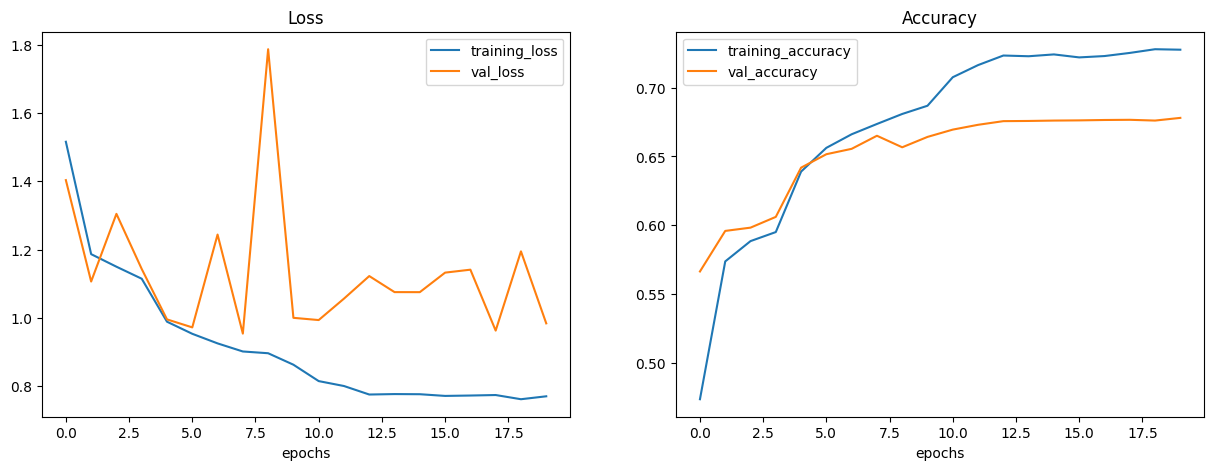

In [30]:
plot_curves(ResNet50V2_history)

In [29]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

113/113 [==============================] - 583s 5s/step


Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

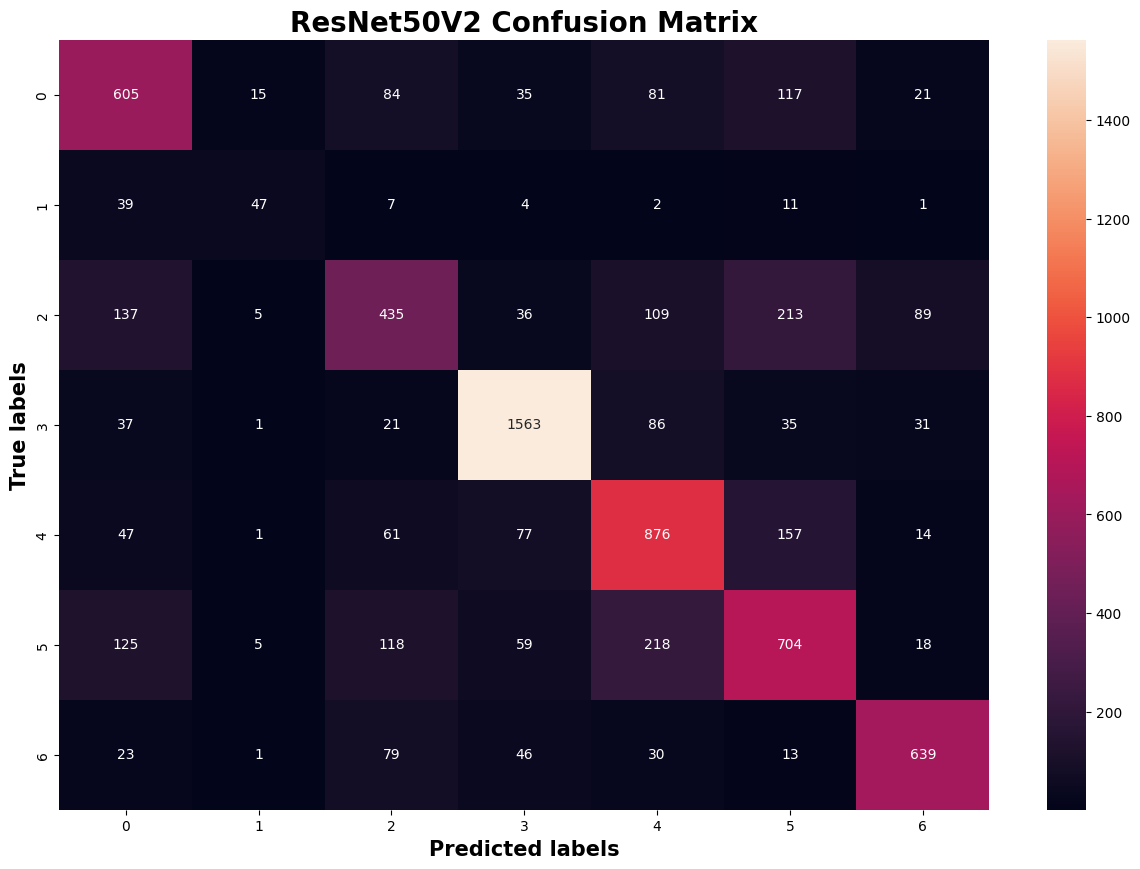

In [31]:
fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

# **Visualizing Predictions**

In [32]:
Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']

In [33]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


**CNN Predictions**

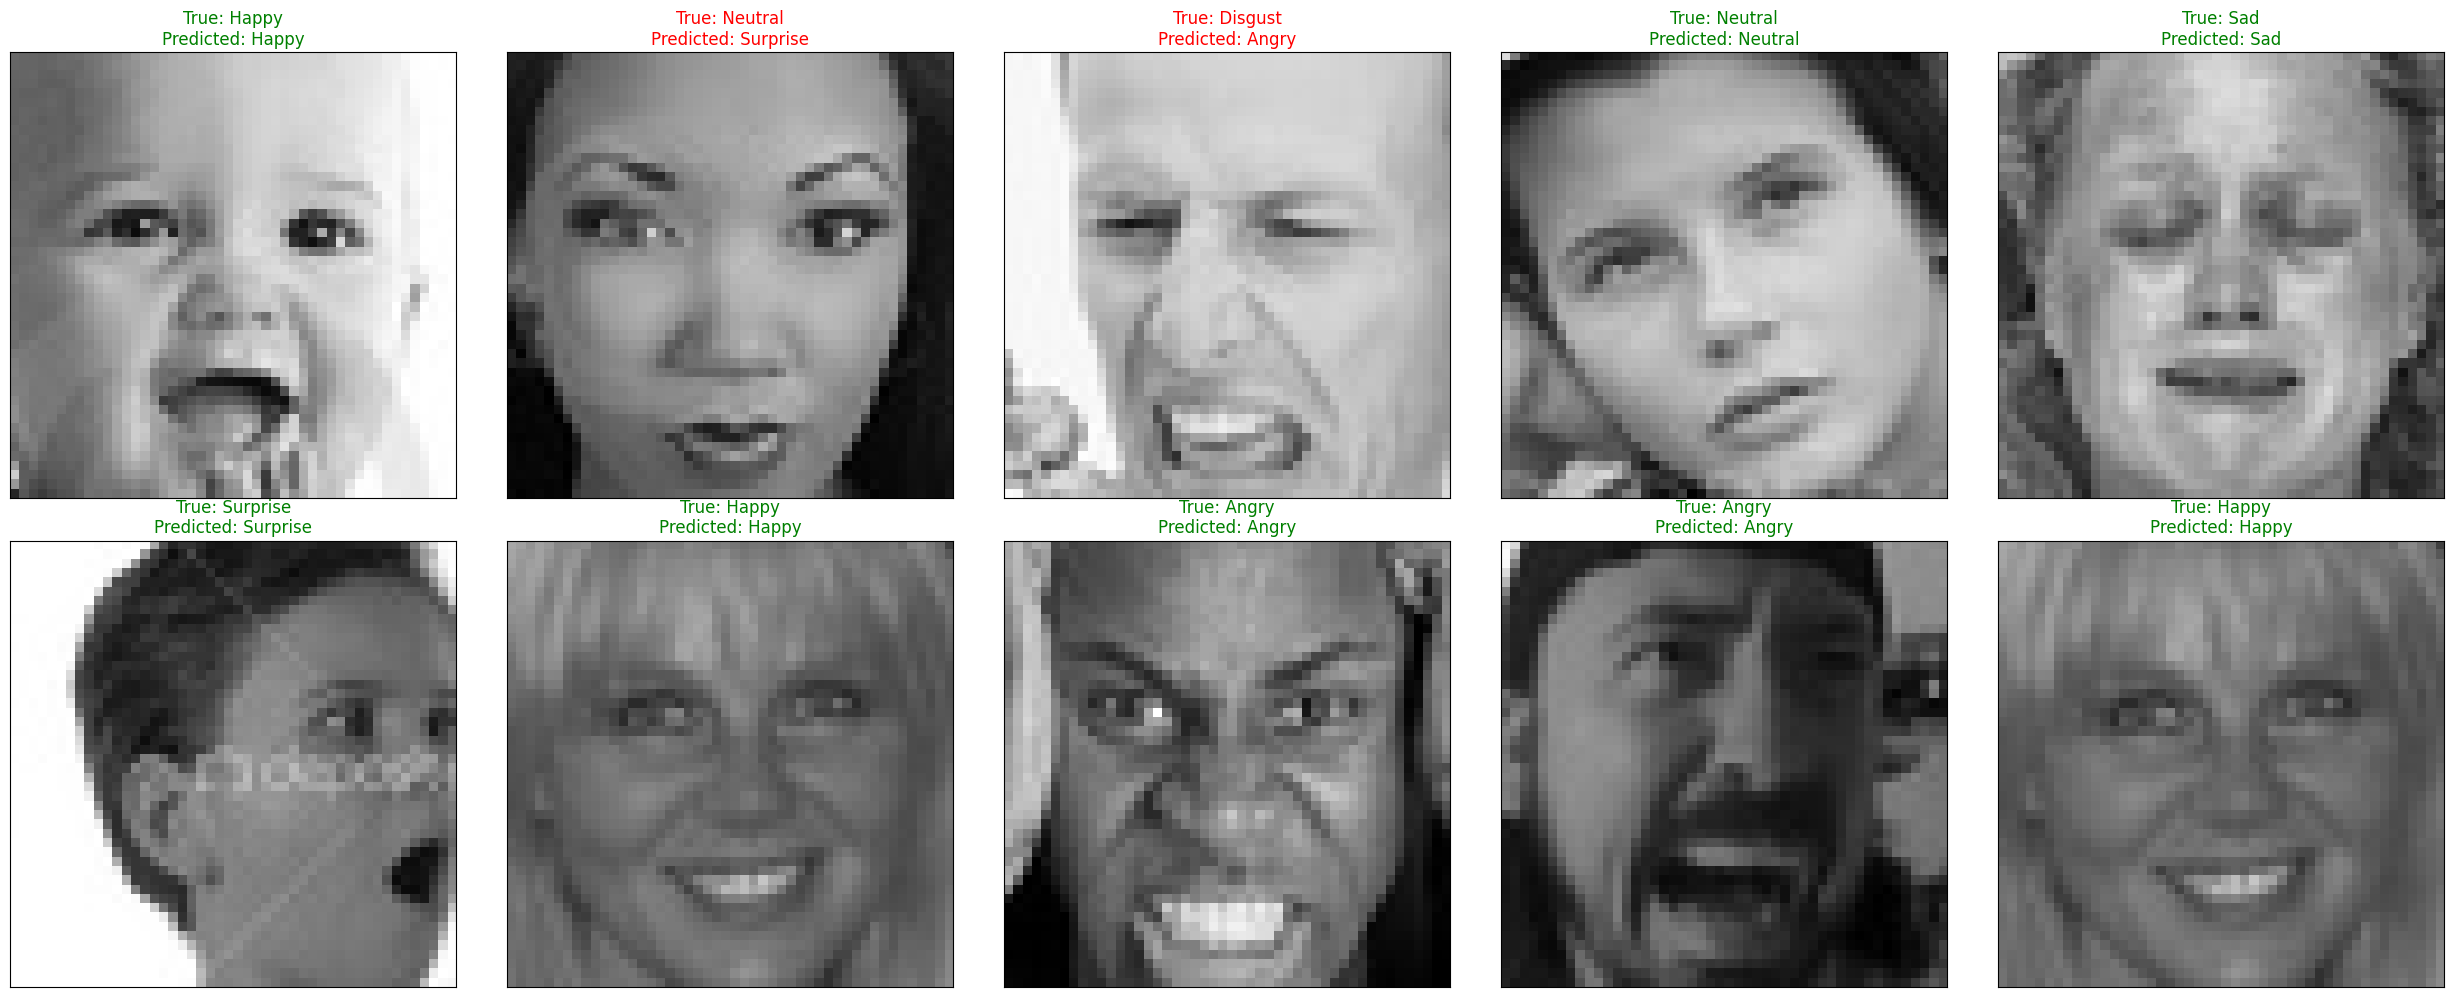

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img = tf.image.resize(Random_Img, (48, 48))  # Resize the image to match the model's input shape

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()


**ResNet50V2 Predictions**

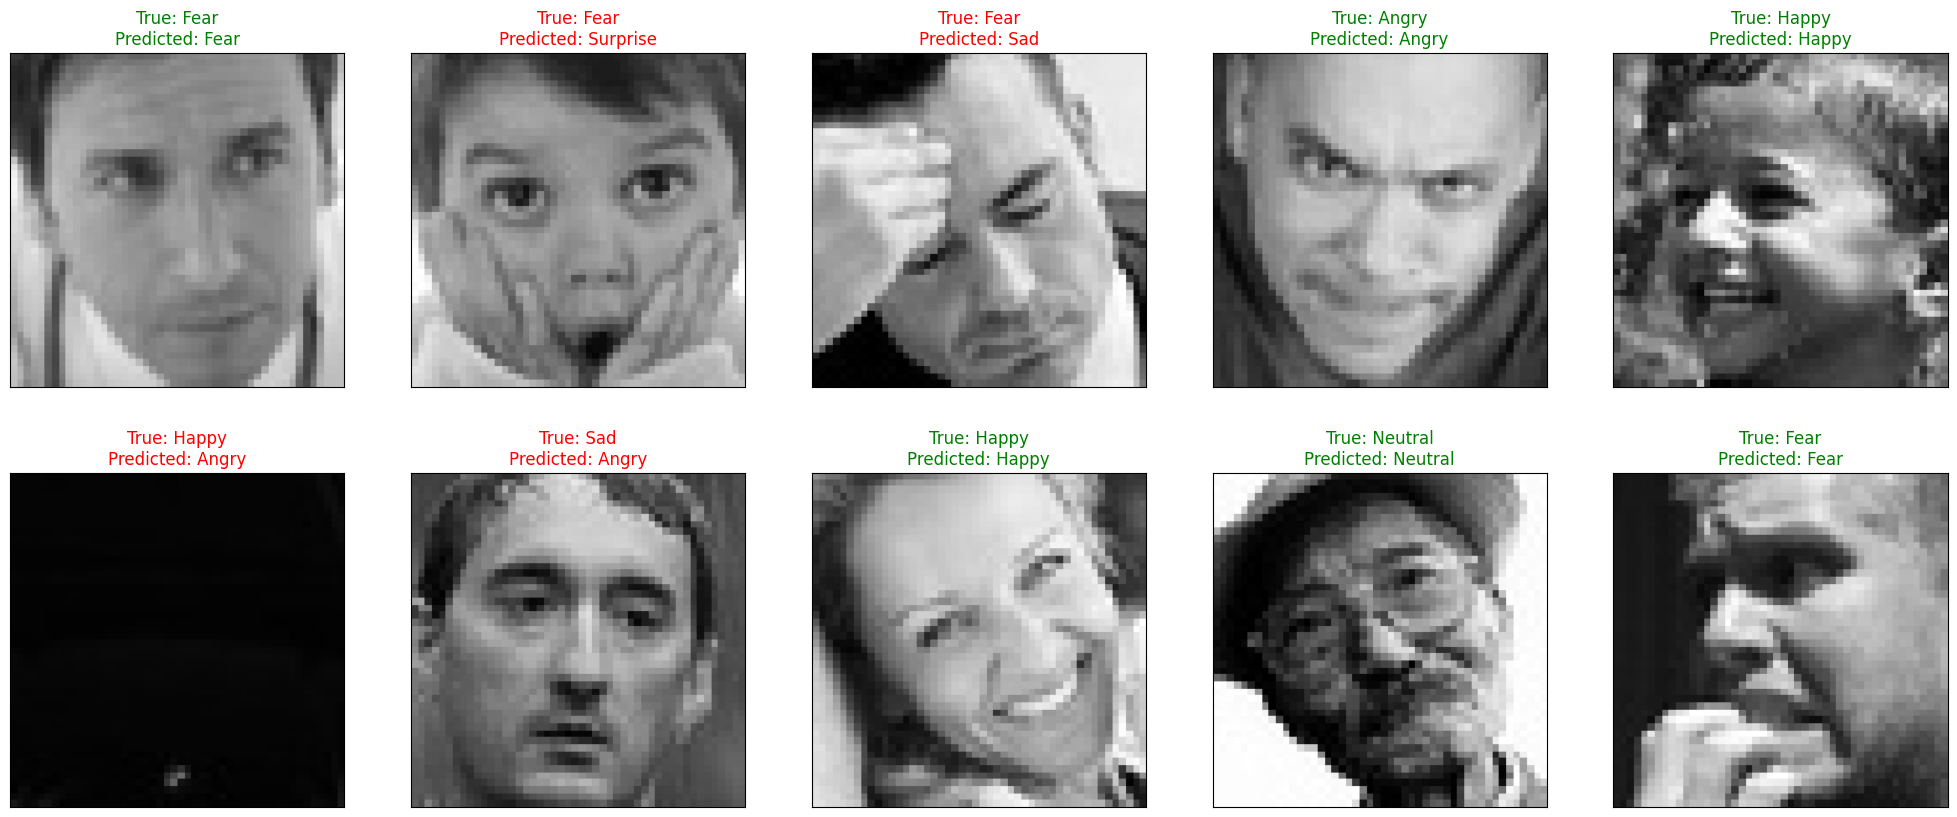

<Figure size 640x480 with 0 Axes>

In [35]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

# **Music Player**

In [36]:
Music_Player = pd.read_csv("data_moods.csv")
Music_Player = Music_Player[['name','artist','mood','popularity']]
Music_Player.head()

name          artist       mood  \
0                                         1999          Prince      Happy   
1                                           23  Blonde Redhead        Sad   
2                                     9 Crimes     Damien Rice        Sad   
3                               99 Luftballons            Nena      Happy   
4  A Boy Brushed Red Living In Black And White       Underoath  Energetic   

   popularity  
0          68  
1          43  
2          60  
3           2  
4          60

In [37]:
Music_Player["mood"].value_counts()

mood
Sad          197
Calm         195
Energetic    154
Happy        140
Name: count, dtype: int64

In [38]:
Music_Player["popularity"].value_counts()

popularity
0     92
51    23
52    22
50    21
55    21
      ..
80     1
2      1
14     1
15     1
88     1
Name: count, Length: 83, dtype: int64

In [39]:
Play = Music_Player[Music_Player['mood'] =='Calm' ]
Play = Play.sort_values(by="popularity", ascending=False)
Play = Play[:5].reset_index(drop=True)
display(Play)

name            artist  mood  popularity
0              Lost           Annelie  Calm          64
1         Curiosity       Beau Projet  Calm          60
2     Escaping Time  Benjamin Martins  Calm          60
3  Just Look at You               369  Calm          59
4             Vague     Amaranth Cove  Calm          59

In [40]:
# Making Songs Recommendations Based on Predicted Class
def Recommend_Songs(pred_class):
    
    if( pred_class=='Disgust' ):

        Play = Music_Player[Music_Player['mood'] =='Sad' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Happy' or pred_class=='Sad' ):

        Play = Music_Player[Music_Player['mood'] =='Happy' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Fear' or pred_class=='Angry' ):

        Play = Music_Player[Music_Player['mood'] =='Calm' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Surprise' or pred_class=='Neutral' ):

        Play = Music_Player[Music_Player['mood'] =='Energetic' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

# **Predicting New Images**

**Downloading OpenCV haarcascade frontalface Detection**

In [52]:
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [53]:
def load_and_prep_image(filename, img_shape = 224):

    img = cv2.imread(filename)

    GrayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)
    
    for x,y,w,h in faces:
        
        roi_GrayImg = GrayImg[ y: y + h , x: x + w ]
        roi_Img = img[ y: y + h , x: x + w ]
        
        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
        
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        
        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)
        
        if len(faces) == 0:
            print("No Faces Detected")
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ ey: ey+eh , ex: ex+ew ]
    
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    RGBImg= cv2.resize(RGBImg,(img_shape,img_shape))

    RGBImg = RGBImg/255.

    return RGBImg

In [54]:
def pred_and_plot(filename, class_names):

    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = ResNet50V2_Model.predict(np.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[pred.argmax()]

    # Plot the image and predicted class
    #plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);
    
    Recommend_Songs(pred_class)

1/1 [==============================] - 0s 163ms/step


name             artist   mood  popularity
0                       Pumped Up Kicks  Foster The People  Happy          84
1                                Africa               TOTO  Happy          84
2                            Take on Me               a-ha  Happy          84
3                       Highway to Hell              AC/DC  Happy          83
4  Here Comes The Sun - Remastered 2009        The Beatles  Happy          83

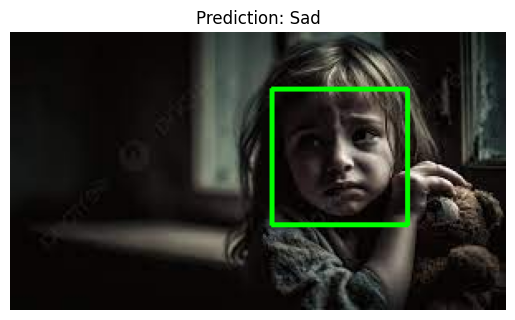

In [55]:
pred_and_plot(r"C:\Users\ASUS\Desktop\senti_new\images\sad2.jpg", Emotion_Classes) # with CNN

In [56]:
# Downloading Image to Test On
import urllib.request

# URL of the image you want to download
image_url = "https://pbs.twimg.com/media/EEY3RFFWwAAc-qm.jpg"

# Specify the file name for the downloaded image
file_name = "sad.jpg"

# Download the image
urllib.request.urlretrieve(image_url, file_name)

('sad.jpg', <http.client.HTTPMessage at 0x1ce28258690>)

No Faces Detected
1/1 [==============================] - 0s 147ms/step


name             artist   mood  popularity
0                       Pumped Up Kicks  Foster The People  Happy          84
1                                Africa               TOTO  Happy          84
2                            Take on Me               a-ha  Happy          84
3                       Highway to Hell              AC/DC  Happy          83
4  Here Comes The Sun - Remastered 2009        The Beatles  Happy          83

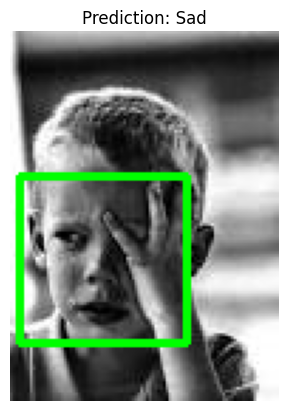

In [57]:
pred_and_plot(r"C:\Users\ASUS\Desktop\senti_new\images\sadpic.jpg", Emotion_Classes) # with CNN

1/1 [==============================] - 0s 172ms/step


name             artist   mood  popularity
0                       Pumped Up Kicks  Foster The People  Happy          84
1                                Africa               TOTO  Happy          84
2                            Take on Me               a-ha  Happy          84
3                       Highway to Hell              AC/DC  Happy          83
4  Here Comes The Sun - Remastered 2009        The Beatles  Happy          83

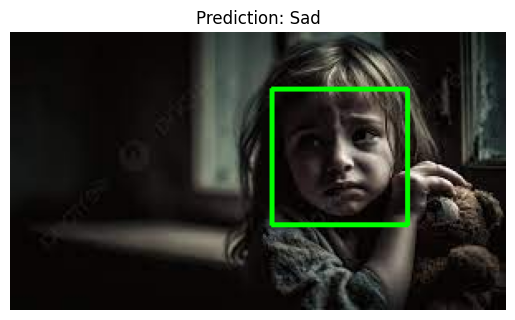

In [58]:
pred_and_plot(r'C:\Users\ASUS\Desktop\senti_reall\images\sad2.jpg', Emotion_Classes) # with ResNet50V2

In [59]:
import urllib.request

# URL of the image
image_url = "https://upload.wikimedia.org/wikipedia/commons/0/09/The_joy_of_the_happy_face_by_Rasheedhrasheed.jpg?20190306144851"

# Specify the file name for the downloaded image
file_name = "happy.jpg"

# Download the image
urllib.request.urlretrieve(image_url, file_name)

('happy.jpg', <http.client.HTTPMessage at 0x1ce2084c350>)

1/1 [==============================] - 0s 163ms/step


name             artist   mood  popularity
0                       Pumped Up Kicks  Foster The People  Happy          84
1                                Africa               TOTO  Happy          84
2                            Take on Me               a-ha  Happy          84
3                       Highway to Hell              AC/DC  Happy          83
4  Here Comes The Sun - Remastered 2009        The Beatles  Happy          83

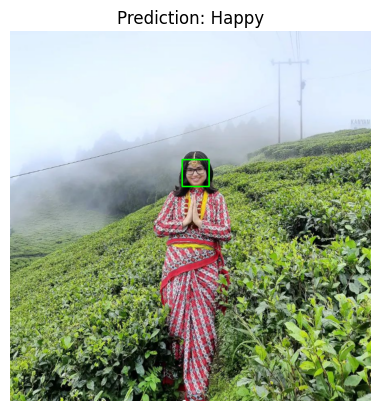

In [60]:
pred_and_plot(r"C:\Users\ASUS\Desktop\senti_new\images\rajanihappy.png", Emotion_Classes) # with ResNet50V2

In [61]:
CNN_Model.save("CNN_Model.keras")

ResNet50V2_Model.save("ResNet50V2_Model.keras")

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import pandas as pd
import random

# Load the trained emotion recognition model (CNN or ResNet50V2)
emotion_model = load_model('CNN_Model.keras')  # Update with your model file

# Load the face detection classifier (Haar Cascades or other)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')  # Update with your classifier

# Define a list of emotion labels for reference
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Calm', 'Energetic']

# Load a sample music dataset for recommendations (e.g., CSV with name, artist, mood, and popularity)
music_data = pd.read_csv('data_moods.csv')  # Update with your dataset

# Open a connection to the camera (0 is typically the default camera)
cap = cv2.VideoCapture(0)

def recommend_music(emotion):
    # Define a mapping of emotions to music categories
    emotion_to_music = {
        "angry": "calm",
        "disgust": "calm",
        "fear": "calm",
        "happy": "happy",
        "sad": "sad",
        "calm": "calm",
        "energetic": "energetic"
    }
    
    # Get the corresponding music category based on the emotion
    music_category = emotion_to_music.get(emotion.lower(), "No recommendations available")

    # Filter music based on the music category
    filtered_music = music_data[music_data['mood'] == music_category]
    
    if not filtered_music.empty:
        if len(filtered_music) >= 5:
            recommended_music = random.choice(filtered_music.sample(n=5))
            return recommended_music['name'], recommended_music['artist']
        else:
            return "No recommendations available", "No recommendations available"
    else:
        return "No recommendations available", "No recommendations available"

while True:
    ret, frame = cap.read()  # Read a frame from the camera

    if not ret:
        break

    # Convert the frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Use the face detection classifier to detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face_roi = gray[y:y + h, x:x + w]
        # Convert grayscale to a 3-channel image (RGB)
        face_img = cv2.cvtColor(face_roi, cv2.COLOR_GRAY2BGR)
        face_img = cv2.resize(face_img, (48, 48))  # Resize the face image to match the model input size
        face_img = np.reshape(face_img, [1, 48, 48, 3])  # Prepare the face image for prediction
        face_img = face_img / 255.0  # Normalize pixel values

        emotion_prediction = emotion_model.predict(face_img)
        predicted_emotion = emotion_labels[np.argmax(emotion_prediction)]

        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw a rectangle around the detected face
        cv2.putText(frame, f'Emotion: {predicted_emotion}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        music_name, music_artist = recommend_music(predicted_emotion)
        cv2.putText(frame, f'Music: {music_name} - {music_artist}', (x, y + h + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Display the frame with bounding boxes, emotion, and music recommendations
    cv2.imshow('Real-Time Emotion Detection & Music Recommendation', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close the window
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 44ms/step


In [65]:
CNN_Model.save("CNN_Model.keras")

ResNet50V2_Model.save("ResNet50V2_Model.keras")